In [1]:
import numpy as np
from scipy.stats import gmean
import mne
from tqdm import tqdm

In [2]:
freq = 500


In [3]:
eeg_raw = mne.io.read_raw('./data/Raw_EDF_Files/p10_Record1.edf') 
eeg_raw.rename_channels({ch_name: ch_name.replace("EEG ", "").replace("-Ref", "") for ch_name in eeg_raw.info['ch_names']})


Extracting EDF parameters from /home/huang/research/snn-seizure-prediction-research/data/Raw_EDF_Files/p10_Record1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"July 09, 2015 05:36:39 GMT"
Experimenter,Unknown
Participant,1785-15
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,70.00 Hz


In [4]:
data = eeg_raw.get_data().T
# Clip the data. (Extract the seizure occurrance period)
SOP = 20 * 60 # seizure occurrance period (s)
SPH = 5 * 60 # seizure prediction horizon
freq = 500
total_length = freq * SOP

record_start = (5, 36, 39) # hour, minute, seconds.

seizure1 = (7, 36, 38)  # hour, minute, seconds.
seizure1_start = ((seizure1[0] - record_start[0]) * 3600 + (seizure1[1] - record_start[1]) * 60 + (seizure1[2] - record_start[2])) * freq
seizure1_length = (60 * 7 + 25) * freq
seizure1_end = seizure1_start + seizure1_length

# clip
seizure_mid = (seizure1_start + seizure1_end) // 2
clip_left = (seizure_mid - total_length // 2)
clip_right = (seizure_mid + total_length // 2)
additional_offset = 0

# Right moving the fragment, if `clip_left` < 0 (seizure happens < 15 minute from the beginning of record.). 
# This operation aims at making prediction area as large as possible.
if (clip_left < 0):
    max_movable_length = seizure1_end - seizure_mid + (seizure1_length // 2)
    additional_offset = min(abs(clip_left), max_movable_length)
    clip_left += additional_offset
    clip_right += additional_offset
    
train_data = data[clip_left: clip_right, :]
seizure_offset = (total_length // 2) - ((seizure1_end - seizure1_start) // 2) + additional_offset

In [5]:
def divide_chunks(data, window_size): 
    for i in range(0, data.shape[0], window_size):  
        yield (i, i + window_size) 

In [6]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection


In [53]:
referential_periods = []
for x in divide_chunks(data[:seizure1_start - SOP * freq,:], 5000):
    referential_periods.append(x)
    
critical_periods = []
critical_area_sizes = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 2, 3, 4, 5, 6, 7, 8,9, 10, 15, 20, 25, 30, 35, 40, 45, 60, 65, 70, 75, 80, 90, 100,  120, 150, 180, 210, 240, 270, 300]) * freq
for x in critical_area_sizes:
    critical_periods.append((seizure1_start - int(x), seizure1_start))
    

In [54]:
def validate_sd_increasing(data, referential_periods, critical_periods):
    
    if referential_periods is None or critical_periods is None:
        raise ValueError
    stds_referential = np.array([np.std(data[period[0]: period[1],:], axis = 0) for period in referential_periods])
    stds_critical = np.array([np.std(data[period[0]: period[1], :], axis = 0) for period in critical_periods])
    n_nodes = stds_referential.shape[1]
    p_values = np.array([ttest_ind(stds_critical[:, node_id] , stds_referential[:, node_id], alternative='greater').pvalue for node_id in range(n_nodes)])

    reject, pvals_corrected = fdrcorrection(p_values)
    #print(pvals_corrected)
    return pvals_corrected


In [55]:
for n_window_sample in np.arange(len(critical_area_sizes), 0, -1):
    window_length = critical_area_sizes[n_window_sample - 1] / freq
    print(f"n={n_window_sample} (length = {window_length}s)", [i for i, e in enumerate(validate_sd_increasing(data, referential_periods, critical_periods[:n_window_sample])) if e < 0.001])

n=40 (length = 300.0s) [5, 6, 8, 9, 13, 14, 15, 18]
n=39 (length = 270.0s) [5, 6, 8, 9, 13, 14, 15, 18]
n=38 (length = 240.0s) [5, 6, 8, 9, 14, 15, 18]
n=37 (length = 210.0s) [5, 6, 8, 9, 14, 15, 18]
n=36 (length = 180.0s) [5, 6, 8, 9, 14, 15, 18]
n=35 (length = 150.0s) [5, 6, 8, 9, 14, 15, 18]
n=34 (length = 120.0s) [6, 8, 9, 14, 15]
n=33 (length = 100.0s) [6, 8, 9, 14, 15]
n=32 (length = 90.0s) [6, 8, 9, 14]
n=31 (length = 80.0s) [8, 9, 14]
n=30 (length = 75.0s) [8, 9, 14]
n=29 (length = 70.0s) [8, 14]
n=28 (length = 65.0s) []
n=27 (length = 60.0s) []
n=26 (length = 45.0s) []
n=25 (length = 40.0s) []
n=24 (length = 35.0s) []
n=23 (length = 30.0s) []
n=22 (length = 25.0s) []
n=21 (length = 20.0s) []
n=20 (length = 15.0s) []
n=19 (length = 10.0s) []
n=18 (length = 9.0s) []
n=17 (length = 8.0s) []
n=16 (length = 7.0s) []
n=15 (length = 6.0s) []
n=14 (length = 5.0s) []
n=13 (length = 4.0s) []
n=12 (length = 3.0s) []
n=11 (length = 2.0s) []
n=10 (length = 1.0s) []
n=9 (length = 0.9s) []
n

In [56]:
def validate_correlation_increasing(data, referential_periods, critical_periods):
    def get_pearson_correlations_single_period(data_segment):
        correlations =  np.corrcoef(data_segment.T)[np.triu_indices(data_segment.shape[1], k = 1)]
        return np.abs(correlations)
    if referential_periods is None or critical_periods is None:
        raise ValueError
    n_channels = data.shape[1]
    n_edges = n_channels * (n_channels - 1) // 2
    
    referential_pearson_correlations = np.array([get_pearson_correlations_single_period(data[period[0]: period[1], :]) for period in referential_periods])
    critical_pearson_correlations =  np.array([get_pearson_correlations_single_period(data[period[0] : period[1],:]) for period in critical_periods])
    p_values = np.array([ttest_ind(critical_pearson_correlations[:, edge_id] , referential_pearson_correlations[:, edge_id], alternative='greater').pvalue for edge_id in range(n_edges)])

    reject, pvals_corrected = fdrcorrection(p_values)
    #print(pvals_corrected)
    return pvals_corrected


In [57]:
n_channels = data.shape[1]
n_edges = n_channels * (n_channels - 1) // 2
for n_window_sample in np.arange(len(critical_area_sizes), 0, -1):
    window_length = critical_area_sizes[n_window_sample - 1] / freq
    print(f"n={n_window_sample} (length = {window_length}s)", [(i // n_channels, i % n_channels) for i, e in enumerate(validate_correlation_increasing(data, referential_periods, critical_periods[:n_window_sample])) if e < 0.001])
    

n=40 (length = 300.0s) [(1, 10), (2, 15), (2, 16), (2, 17), (2, 18), (3, 4), (3, 5), (3, 7), (3, 8), (5, 5), (5, 7), (5, 10), (5, 16), (5, 18), (6, 9), (6, 18), (8, 13)]
n=39 (length = 270.0s) [(1, 10), (2, 15), (2, 16), (2, 17), (2, 18), (3, 2), (3, 4), (3, 5), (3, 7), (3, 8), (5, 5), (5, 7), (5, 10), (5, 16), (5, 18), (6, 9), (6, 18), (8, 13)]
n=38 (length = 240.0s) [(1, 10), (2, 15), (2, 16), (2, 17), (2, 18), (3, 2), (3, 4), (3, 5), (3, 7), (3, 8), (5, 5), (5, 7), (5, 10), (5, 16), (5, 18), (6, 0), (6, 9), (6, 18), (8, 13)]
n=37 (length = 210.0s) [(1, 10), (2, 15), (2, 16), (2, 17), (2, 18), (3, 2), (3, 4), (3, 5), (3, 7), (3, 8), (5, 5), (5, 7), (5, 10), (5, 16), (5, 18), (6, 0), (6, 9), (6, 18), (8, 13)]
n=36 (length = 180.0s) [(1, 10), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (3, 2), (3, 4), (3, 5), (3, 7), (3, 8), (4, 17), (5, 5), (5, 7), (5, 10), (5, 11), (5, 16), (5, 18), (6, 0), (6, 9), (6, 18), (7, 10), (8, 10), (8, 13)]
n=35 (length = 150.0s) [(1, 10), (2, 14), (2, 15)

In [3]:
referential_dataset = mne.io.read_raw('./data/Raw_EDF_Files/p10_Record2.edf')
referential_dataset.rename_channels({ch_name: ch_name.replace("EEG ", "").replace("-Ref", "") for ch_name in referential_dataset.info['ch_names']})

Extracting EDF parameters from /home/huang/research/snn-seizure-prediction-research/data/Raw_EDF_Files/p10_Record2.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...


Measurement date,"July 10, 2015 04:29:14 GMT"
Experimenter,Unknown
Participant,1785-15
Digitized points,Not available
Good channels,19 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,500.00 Hz
Highpass,1.00 Hz
Lowpass,70.00 Hz


In [4]:
from pyprep.prep_pipeline import PrepPipeline

def preprocess(raw):
    montage_kind = "standard_1020"
    montage = mne.channels.make_standard_montage(montage_kind)
    sample_rate = raw.info["sfreq"]
    prep_params = {
        "ref_chs": "eeg",
        "reref_chs": "eeg",
        "line_freqs": np.arange(60, sample_rate / 2, 60),
    }
    prep = PrepPipeline(raw, prep_params, montage)
    prep.fit()



In [5]:
preprocess(eeg_raw)
preprocess(referential_dataset)

Reading 0 ... 5401499  =      0.000 ... 10802.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Removed notch frequencies (Hz):
     60.00 : 41021 windows
    120.00 : 41021 windows
    180.00 : 41021 windows
    239.00 :   19 windows
    240.00 : 41021 windows
    241.00 :   19 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.7s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


/home/huang/anaconda3/envs/py39/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████|  : 2160/2160 [01:48<00:00,   19.97it/s]


RANSAC done!



2024-08-07 14:55:53,973 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['C4', 'T4'], 'bad_by_correlation': ['C4'], 'bad_by_SNR': ['C4'], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['T4', 'C4']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2160/2160 [02:00<00:00,   17.89it/s]



RANSAC done!


2024-08-07 14:58:28,692 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['F4'], 'bad_by_hf_noise': [], 'bad_by_correlation': [], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('C4'), np.str_('F7')], 'bad_all': [np.str_('F7'), 'F4', np.str_('C4')]}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 16 sensor positions
Interpolating 3 sensors


2024-08-07 14:58:30,096 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2160/2160 [02:03<00:00,   17.52it/s]



RANSAC done!


2024-08-07 15:01:02,075 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['F4'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C4'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('A2'), np.str_('C4'), np.str_('F7')], 'bad_all': [np.str_('A2'), 'F4', np.str_('F7'), 'C4']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 15 sensor positions
Interpolating 4 sensors


2024-08-07 15:01:03,462 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2160/2160 [02:05<00:00,   17.16it/s]


RANSAC done!



2024-08-07 15:03:37,937 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': ['F4'], 'bad_by_hf_noise': [], 'bad_by_correlation': ['C4'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('A2'), np.str_('C4'), np.str_('F7')], 'bad_all': [np.str_('A2'), 'F4', np.str_('F7'), 'C4']}
2024-08-07 15:03:37,937 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 15 sensor positions
Interpolating 4 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2160/2160 [02:04<00:00,   17.30it/s]


RANSAC done!
Found 1 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

0 by correlation: []

0 by SNR: []

0 by dropout: []

1 by RANSAC: [np.str_('A2')]



Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 17 sensor positions
Interpolating 2 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2160/2160 [01:50<00:00,   19.54it/s]


RANSAC done!


Reading 0 ... 5399499  =      0.000 ... 10798.998 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Removed notch frequencies (Hz):
     60.00 : 41002 windows
    120.00 : 41002 windows
    180.00 : 41002 windows
    239.00 :   19 windows
    240.00 : 41002 windows
    241.00 :   19 windows
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2159/2159 [01:35<00:00,   22.56it/s]


RANSAC done!



2024-08-07 15:13:09,354 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': ['T4'], 'bad_by_correlation': ['C4'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [np.str_('A2')], 'bad_all': [np.str_('A2'), 'T4', 'C4']}


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2159/2159 [01:38<00:00,   21.93it/s]


RANSAC done!



2024-08-07 15:15:22,434 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['A2'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['A2']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors


2024-08-07 15:15:23,911 - pyprep.reference - INFO - Iterations: 1


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2159/2159 [01:31<00:00,   23.61it/s]


RANSAC done!



2024-08-07 15:17:23,848 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['A2'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['A2']}


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors


2024-08-07 15:17:25,330 - pyprep.reference - INFO - Iterations: 2


NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2159/2159 [01:31<00:00,   23.57it/s]



RANSAC done!


2024-08-07 15:19:25,511 - pyprep.reference - INFO - Bad channels: {'bad_by_nan': [], 'bad_by_flat': [], 'bad_by_deviation': [], 'bad_by_hf_noise': [], 'bad_by_correlation': ['A2'], 'bad_by_SNR': [], 'bad_by_dropout': [], 'bad_by_ransac': [], 'bad_all': ['A2']}
2024-08-07 15:19:25,512 - pyprep.reference - INFO - Robust reference done


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2159/2159 [01:27<00:00,   24.61it/s]


RANSAC done!


Found 1 uniquely bad channels:

0 by NaN: []

0 by flat: []

0 by deviation: []

0 by HF noise: []

1 by correlation: ['A2']

0 by SNR: []

0 by dropout: []

0 by RANSAC: []

Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.4 mm
Computing interpolation matrix from 18 sensor positions
Interpolating 1 sensors
NOTE: pick_types() is a legacy function. New code should use inst.pick(...).
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 1651 samples (3.302 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Executing RANSAC
This may take a while, so be patient...


100%|██████████|  : 2159/2159 [02:09<00:00,   16.63it/s]


RANSAC done!


In [8]:
class DynamicalNetworkBioMarker():
    def __init__(self, referential_dataset):
        self._init_referential_parameters(referential_dataset)
    def _init_referential_parameters(self, referential_dataset):
        data = referential_dataset.get_data()
        node_averages = np.average(data, axis = 1)
        self.node_averages = node_averages
        self.referential_data = data
        self.PCC_n = []
        self.PCC_n_numerator = []
        self.PCC_n_x_square_sum = []
        self.PCC_n_y_square_sum = []

        for i in range(len(node_averages)):
            for j in range(i + 1, len(node_averages)):
                PCC_n_numerator = np.sum(((data[i, :] - node_averages[i]) * (data[j, :] - node_averages[j])))
                x_square_sum = np.sum((data[i, :] - node_averages[i]) ** 2)
                y_square_sum =  np.sum((data[j, :] - node_averages[j]) ** 2)
                PCC_n_denominator = np.sqrt(x_square_sum * y_square_sum)
                self.PCC_n_x_square_sum.append(x_square_sum)
                self.PCC_n_y_square_sum.append(y_square_sum)
                self.PCC_n_numerator.append(PCC_n_numerator)
                self.PCC_n.append(PCC_n_numerator / PCC_n_denominator)
    
    def inference_dnb_index(self, data, time_steps = None):
        cnt_nodes = data.shape[1]
        DNB_indexes = []
        if time_steps is None:
            time_steps = data.shape[0]
        for t in tqdm(range(time_steps)):
            sample_t = data[t]
            sample_t_deviation = (sample_t - self.node_averages)
            sED = gmean(sample_t_deviation ** 2)
            sPCCs = []
            n = 0
            for i in range(cnt_nodes):
                for j in range(i + 1, cnt_nodes):
                    PCC_n = self.PCC_n[n]
                    new_pearson_correlation_numerator = self.PCC_n_numerator[n] + (sample_t_deviation[i]) * (sample_t_deviation[j])
                    new_pearson_correlation_denominator = \
                        np.sqrt((self.PCC_n_x_square_sum[n] + (sample_t_deviation[i]) ** 2) * \
                        (self.PCC_n_y_square_sum[n] + (sample_t_deviation[j]) ** 2))
                    PCC_n_plus_1 = (new_pearson_correlation_numerator / new_pearson_correlation_denominator)
                    pcc_i_j = PCC_n_plus_1 - PCC_n
                    sPCCs.append(np.abs(pcc_i_j))
                    n += 1
            sPCC = gmean(sPCCs)
            DNB_indexes.append(sED * sPCC)
        return DNB_indexes

In [9]:
dnb = DynamicalNetworkBioMarker(referential_dataset)

In [10]:
data = eeg_raw.get_data().T

In [11]:
dnb_indexes = dnb.inference_dnb_index(data)

100%|██████████| 5401500/5401500 [1:31:50<00:00, 980.30it/s]


In [16]:
len(dnb_indexes)

5401500

In [17]:
time_steps = data.shape[0]
node_count = data.shape[1]
Rho = np.zeros((time_steps))
records_in_window = []

In [23]:
def calculate_sigma(data):
    avg_eeg_data = np.average(data, axis = 0)
    N = data.shape[0]
    deviation = (data - avg_eeg_data)
    deviation_pow_2 = deviation ** 2 
    return np.sqrt(np.sum(deviation_pow_2, axis = 0) / N)

def calculate_abs_rho(data):
    pearson_correlation_coefficient_matrix = np.corrcoef(data.T)
    return np.abs(pearson_correlation_coefficient_matrix[np.triu_indices(data.shape[1], k = 1)])



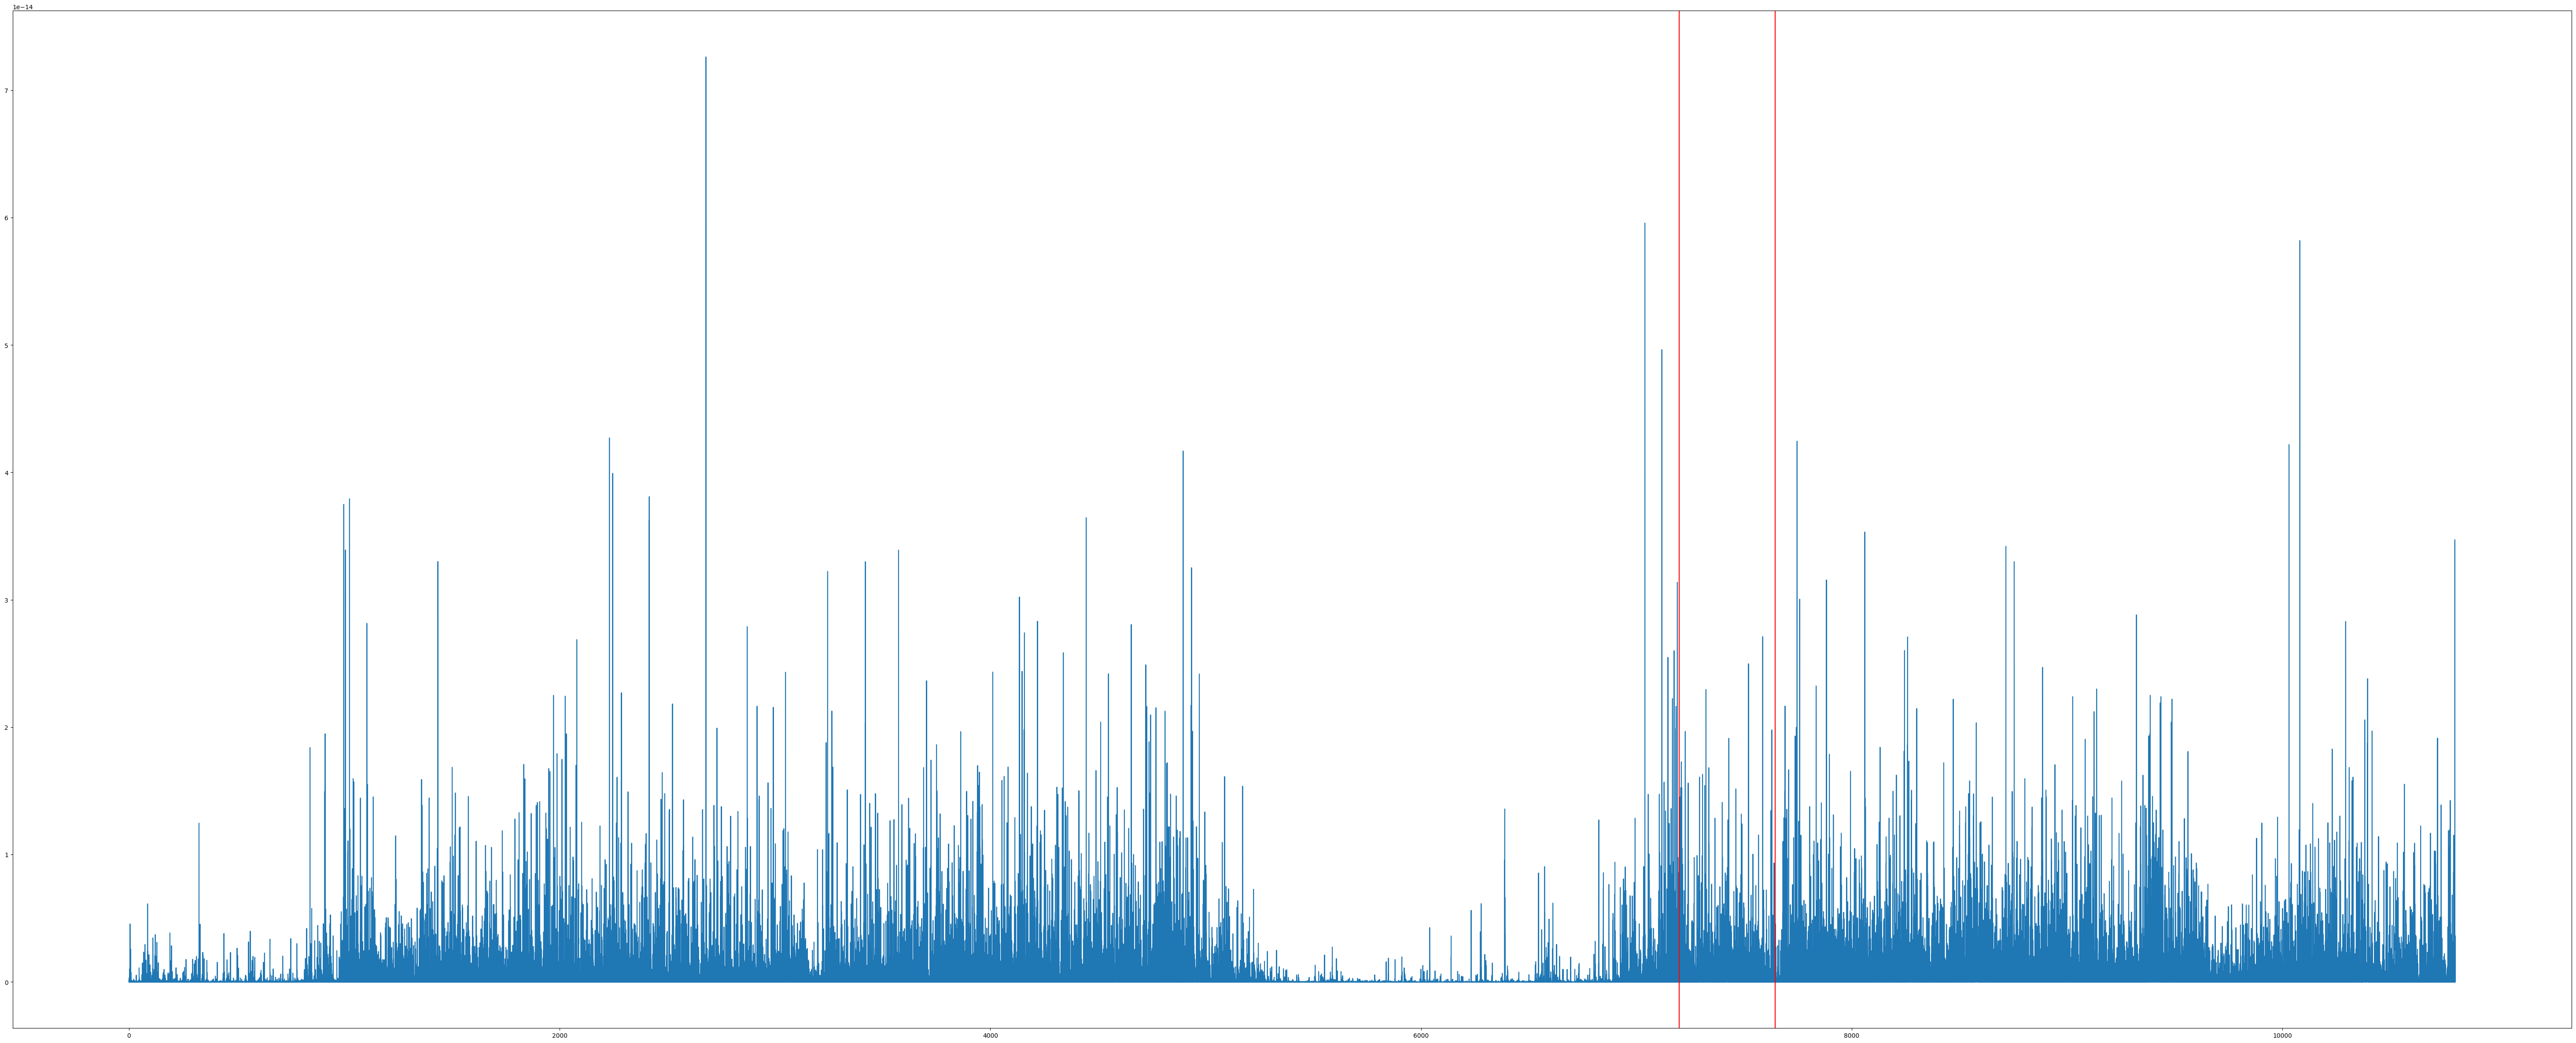

In [35]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(75, 30))
freq = 500
dt = 1 / freq
plt.plot(np.arange(0, len(dnb_indexes)) * dt, dnb_indexes)
plt.axvline(x=seizure1_start * dt, c= "red")

plt.axvline(x=(seizure1_start + seizure1_length) * dt, c= "red")